# Context – Drunk Smurfs
Among all international hotel guests, Smurfs are burdened with the upkeep of a singular reputation: they are (supposedly) the rowdiest bunch one can entertain, and are equally well-known for unbridled spending as for racking up extensive costs in damages to hotel infrastructure, staff, and occasionally also other guests – costs which typically cannot be recovered once the guest has sought out the safety of his (or her) homeland.
It is your job as a data scientist to screen applying Smurfs clients for an exclusive hotel in the Bahamas - yes, it's the kind of hotel you need to apply for!
# The data
At your disposal is a training set containing data about the behavior of 5000 Smurf hotel guests (train_V2.csv). This data set contains information about the profit the hotel made during their last visit (excluding damages), but also whether they caused damages during their last visit, and for what amount. These outcomes are respectively called 'outcome_profit', 'outcome_damage_inc', and 'outcome_damage_amount'. To predict them, you have access to a host of personal information: previous history of profits and damages, use of hotel facilities, socio-demographics and behavioral scores from the staff of other hotels within the hotel chains. A minor description of features is available in dictionary.csv.
You also get information on the 500 applicants for the 2024 season (score.csv). It is your job to return a list of 150 clients that offer an attractive balance between projected profit for the hotel, and anticipated damages. 
You will notice the data set contains a large number of oddities. You are expected to think yourself about what is intuitive and acceptable in terms of approach, and to provide some minor reflection on this in your technical report. 


# Possible approach
To generate a client list, you can (but don't have to) follow the next steps:
1)	prepare the data set	
* briefly survey the data
* deal with data issues:
* appropriate handle categorical data
* treat missing data
* identify outliers, and choose whether to make your analysis more robust by removing these
2)	predict the projected revenue per clients
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
3)	predict which clients will cause damage
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
4)	for those that will wreak havoc, predict the amount of damage they will cause
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
5)	create a measure of the expected value of each applicant, and create an optimal selection of 200 guests


## 0. Loading packages and dataset

In [74]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-darkgrid')   

C:\Users\tomas\AppData\Local\Temp\ipykernel_19764\1617307288.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [75]:
# read in data
train = pd.read_csv('train_V2.csv')
score = pd.read_csv('score.csv')

## 1. Data exploration

1. and 2: number of features and observations

In [76]:
train.shape

(5000, 53)

In [77]:
# correlation matrix
corr_matrix = train.corr()
print(corr_matrix)
# Geen variabelen die een correlatie van 1 hebben dus op basis daarvan moeten we geen variabelen weglaten.


                       income_am  profit_last_am  profit_am  damage_am  \
income_am               1.000000        0.716032   0.685038   0.102339   
profit_last_am          0.716032        1.000000   0.424888   0.099840   
profit_am               0.685038        0.424888   1.000000   0.164160   
damage_am               0.102339        0.099840   0.164160   1.000000   
damage_inc              0.022713        0.046216   0.146981   0.622453   
crd_lim_rec             0.112643        0.058381   0.208033   0.288919   
credit_use_ic           0.043790        0.068244   0.114818   0.101889   
gluten_ic               0.158987        0.115330   0.167896   0.037240   
lactose_ic              0.287967        0.139112   0.404624   0.017174   
insurance_ic            0.006980        0.017561   0.058299   0.173917   
spa_ic                  0.000436        0.004509   0.038036   0.021302   
empl_ic                -0.018407       -0.008958  -0.016365   0.015352   
cab_requests            0.055035      

C:\Users\tomas\AppData\Local\Temp\ipykernel_19764\3726449561.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


# Check for constant variables

In [78]:
# There are no constant variables so we do not need to ommit any based on this information.
constant_columns = [col for col in train.columns if train[col].nunique() == 1]
print(constant_columns)

[]


In [79]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
income_am,4947.0,2281.260158,8365.254507,0.000000e+00,229.000000,469.000000,1688.000000,360577.000000
profit_last_am,4947.0,696.057712,3051.119275,0.000000e+00,0.000000,52.000000,810.000000,150537.000000
profit_am,4947.0,3637.900950,5726.625669,0.000000e+00,1638.000000,1889.000000,3165.500000,100577.000000
damage_am,4954.0,145.952967,581.068095,0.000000e+00,0.000000,0.000000,0.000000,14866.000000
damage_inc,4947.0,0.352335,0.889449,0.000000e+00,0.000000,0.000000,0.000000,10.000000
crd_lim_rec,4947.0,3298.716394,4549.646039,0.000000e+00,0.000000,1500.000000,5000.000000,30000.000000
credit_use_ic,4947.0,0.041237,0.198858,0.000000e+00,0.000000,0.000000,0.000000,1.000000
gluten_ic,4947.0,0.024661,0.155107,0.000000e+00,0.000000,0.000000,0.000000,1.000000
lactose_ic,4947.0,0.094199,0.292134,0.000000e+00,0.000000,0.000000,0.000000,1.000000
insurance_ic,4947.0,0.390944,0.488011,0.000000e+00,0.000000,0.000000,1.000000,1.000000


In [80]:
train[0:500].T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
income_am,227.0,268.0,283.0,227.0,4091.0,5108.0,13293.0,227.0,229.0,229.0,...,275.0,3655.0,227.0,3611.0,227.0,1564.0,1928.0,1010.0,1186.0,227.0
profit_last_am,0.0,16.0,23.0,0.0,1028.0,289.0,28.0,0.0,810.0,810.0,...,20.0,1441.0,0.0,1371.0,0.0,2656.5,20.0,243.0,403.0,0.0
profit_am,3201.0,1682.0,1673.0,1685.0,3425.0,6280.0,14704.0,1620.0,1620.0,1620.0,...,1630.0,2185.0,1620.0,2181.0,1620.0,5313.0,7426.0,1819.0,1771.0,1910.0
damage_am,888.0,0.0,0.0,0.0,785.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
damage_inc,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
crd_lim_rec,15000.0,750.0,750.0,0.0,14000.0,0.0,15000.0,0.0,0.0,0.0,...,0.0,0.0,15000.0,4000.0,0.0,0.0,0.0,7000.0,4500.0,4000.0
credit_use_ic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gluten_ic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lactose_ic,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insurance_ic,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


3. Check for datatypes

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  spor

4. and 5. Check for missing data

In [82]:
#Here we check how many missing values we have per variable.
train.isnull().sum()[train.isnull().sum() != 0]

income_am             53
profit_last_am        53
profit_am             53
damage_am             46
damage_inc            53
crd_lim_rec           53
credit_use_ic         53
gluten_ic             53
lactose_ic            53
insurance_ic          53
spa_ic                30
empl_ic                1
cab_requests          88
bar_no                53
sport_ic              53
neighbor_income      239
age                   53
marketing_permit      53
urban_ic              53
dining_ic             88
presidential          88
client_segment        53
sect_empl             53
prev_stay             53
prev_all_in_stay      53
divorce               53
fam_adult_size        53
children_no           53
tenure_mts           392
tenure_yrs           392
company_ic            53
claims_no             53
claims_am             27
nights_booked         53
gender                53
shop_am               53
shop_use              88
retired               53
gold_status           53
score1_pos          3775


In [83]:
#here we look at what percentage of the observations are not NaN per variable
(5000- train.isnull().sum()[train.isnull().sum() != 0])/5000*100

income_am           98.94
profit_last_am      98.94
profit_am           98.94
damage_am           99.08
damage_inc          98.94
crd_lim_rec         98.94
credit_use_ic       98.94
gluten_ic           98.94
lactose_ic          98.94
insurance_ic        98.94
spa_ic              99.40
empl_ic             99.98
cab_requests        98.24
bar_no              98.94
sport_ic            98.94
neighbor_income     95.22
age                 98.94
marketing_permit    98.94
urban_ic            98.94
dining_ic           98.24
presidential        98.24
client_segment      98.94
sect_empl           98.94
prev_stay           98.94
prev_all_in_stay    98.94
divorce             98.94
fam_adult_size      98.94
children_no         98.94
tenure_mts          92.16
tenure_yrs          92.16
company_ic          98.94
claims_no           98.94
claims_am           99.46
nights_booked       98.94
gender              98.94
shop_am             98.94
shop_use            98.24
retired             98.94
gold_status 

## b) Look at the data


In [84]:
#here we look at the first 16 variables
train.iloc[:,0:16].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0


In [85]:
#here we look at the variables starting from the 16th just to see what the data looks like
train.iloc[:,16:53].head()

,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


## Plot the data

<Axes: xlabel='count', ylabel='gender'>

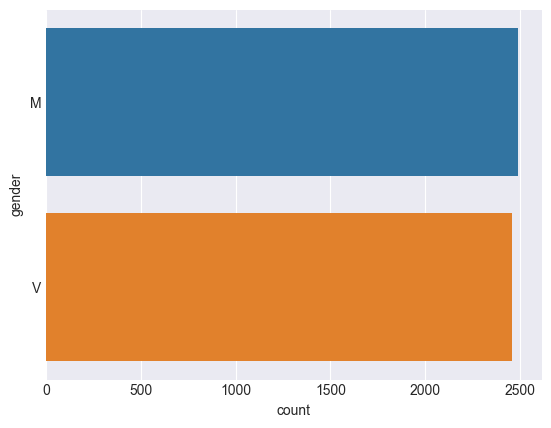

In [86]:
# Look at the amount of men and women with a bar chart
sns.countplot(y=train["gender"])

C:\Users\tomas\AppData\Local\Temp\ipykernel_19764\2512075102.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.corr()


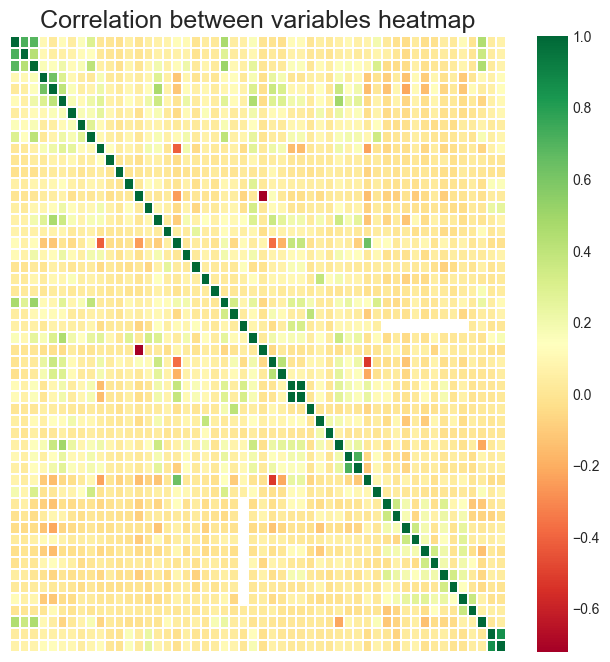

In [87]:
corrmat = train.corr()

fig, ax = plt.subplots(figsize=(8,8))

# Add title to the Heat map
title = "Correlation between variables heatmap"

# Set the font size and the distance of the title from the plot
plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

# Hide ticks for X & Y axis
ax.set_xticks([])
ax.set_yticks([])

# Remove the axes
ax.axis('off')

sns.heatmap(corrmat,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)

plt.show()


In [88]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_damage_inc"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[50:53]))

# plt.show()

In [89]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_profit"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[50:53]))

# plt.show()

In [90]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_damage_amount"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[50:53]))

# plt.show()

We calculate the z_scores of each data point and identify outliers as data points with a score greater than 3, here for 'outcome_damage_amount'

In [91]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_damage_amount'] - train['outcome_damage_amount'].mean()) / train['outcome_damage_amount'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_damage_amount"]))

92


We calculate the z_scores of each data point and identify outliers as data points with a score greater than 3, here for 'outcome_profit'

In [92]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_profit'] - train['outcome_profit'].mean()) / train['outcome_profit'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_profit"]))

72


We calculate the z_scores of each data point and identify outliers as data points with a score greater than 3, here for 'outcome_damage_inc'

In [93]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_damage_inc'] - train['outcome_damage_inc'].mean()) / train['outcome_damage_inc'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_damage_inc"]))

0


In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  spor

## c) Look at the descriptives
1. For which features do you suspect outliers?
2. Which of these outliers seem most suspicious? Which would you certainly check if you were able to?

In [95]:
train.iloc[:,0:16].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0


2. Convert categorical

In [96]:
# Deze variabele is een boolean maar moet een getal worden
train['married_cd'] = train['married_cd'].astype('int')
train.loc[:, 'married_cd']

score['married_cd'] = score['married_cd'].astype('int')

## Clean the data

1. Drop duplicates

In [97]:
train = train.drop_duplicates()
train.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


2. Replace all NaN values with '-1'

In [98]:
# Replace all NaN values with a specified value (e.g., 0)
train.fillna(-1, inplace=True)
train.head()

score.fillna(-1, inplace=True)

In [99]:
na = train.isna()
columns_with_na = train.columns[na.any()].tolist() 
print(len(columns_with_na))

0


3. Drop irrelvant columns

gluten_ic and lactose_ic: The fact that a person is gluten or lactose intolerant does not indicate how likely it is for them to inflict damages or how much money they will be spending in the hotel. Maybe they will pay a tiny bit more for food without those ingredients but it shouldn't have a significant impact.

cab_requests: The hotel is very unlikely to own the cab company so wether or not they buy a lot of taxis will not influence the profit for the hotel.

marketing_permit: The choice on wether or not the marketing team may contact them will not influence how much money they will be spending nor how likely they are to inflict damages.

region: Although region could be a small factor due to cultural diferences in spending and personal traits, this could lead to discrimination of people of a certain region.

gender: Here it could also be that a cerain gender is for example more aggressive than others and thus more likely to inflict damages, but this could also lead to discrimination based on generalisations.

divorce: Being divorced or not does not impact the way you behave or spend money, definitely not if some time has passed. Maybe the first months they could be a bit more aggressive or impulsive due to their grief.

In [100]:
# drop the columns that are not needed
train = train.drop(['gluten_ic', 'lactose_ic', 'marketing_permit','divorce', 'cab_requests', 'urban_ic', 'gender', "married_cd"], axis=1) #outcome_damage_inc, outcome_damage_amount
score = score.drop(['gluten_ic', 'lactose_ic', 'marketing_permit', 'divorce', 'cab_requests', 'urban_ic', 'gender', "married_cd"], axis=1)

 I make sure all three categorical features are classified as 'object' to be able to check if they are categorical

4. Remove unwanted outliers


No unwanted outliers found

## 2. Machine Learning 


Train the different ML models to predict projected revenue


### 2.0.0 Split the data in test/train and standardize data


In [101]:
from sklearn.preprocessing import StandardScaler

X = train
X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
y = train['outcome_profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train_stan = X_train.copy()
X_test_stan = X_test.copy()

X_train_stan[num_feat] = scaler.transform(X_train[num_feat])
X_test_stan[num_feat] = scaler.transform(X_test[num_feat])

### 2.0.1 Lineair Regression

In [102]:
# Dit algoritme heeft een score van 0.2842767456180185

# Train a linear regression model
LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)

# Evaluate the model on the testing set
testScore = LRmodel.score(X_test, y_test)
print('R^2 score on testing set:', testScore)

LRy_pred = LRmodel.predict(X_test)

# Predict the projected revenue for the 500 applicants

LRscore = scaler.transform(score)
LRpredictions = LRmodel.predict(LRscore)

# Sort the predictions in descending order
sorted_index = np.argsort(LRpredictions)[::-1]
LRsorted_predictions = LRpredictions[sorted_index]

print(LRsorted_predictions)

R^2 score on testing set: 0.2848390537607094
[ 8.44471672e+03  3.70269918e+03  3.22350945e+03  3.16722893e+03
  3.15452225e+03  3.00485906e+03  2.98363467e+03  2.93388048e+03
  2.87350717e+03  2.87050209e+03  2.82478811e+03  2.82142059e+03
  2.74784364e+03  2.72606755e+03  2.71479822e+03  2.68213425e+03
  2.67083464e+03  2.65098283e+03  2.63695267e+03  2.63151119e+03
  2.62151268e+03  2.61075859e+03  2.58755242e+03  2.57338778e+03
  2.57116970e+03  2.56552279e+03  2.56373127e+03  2.56051999e+03
  2.56037271e+03  2.55727157e+03  2.55650536e+03  2.55587082e+03
  2.55545989e+03  2.54921772e+03  2.52738797e+03  2.52560125e+03
  2.52276814e+03  2.49909144e+03  2.49522002e+03  2.48774326e+03
  2.48283615e+03  2.46607533e+03  2.46357036e+03  2.45730433e+03
  2.44548520e+03  2.44332017e+03  2.42533017e+03  2.41955820e+03
  2.41467532e+03  2.40535253e+03  2.39610253e+03  2.39230657e+03
  2.39171730e+03  2.39021483e+03  2.38405291e+03  2.37588375e+03
  2.36900751e+03  2.36831360e+03  2.36788118e

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Lineair Regression

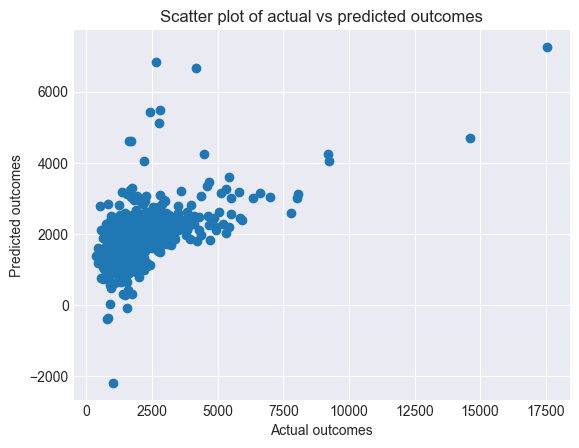

In [103]:
plt.scatter(y_test, LRy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.2 KNN 

In [104]:
# Heeft een score van 0.025000182087153267
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Train a linear regression model
KNNmodel = KNeighborsRegressor(n_neighbors=5)
KNNmodel.fit(X_train, y_train)

# Make predictions on the testing set
KNNy_pred = KNNmodel.predict(X_test)

# Evaluate the model using r-squared score
r2 = r2_score(y_test, KNNy_pred)
print('R-squared score:', r2)

# Predict the projected revenue for the 500 applicants
KNNscore = scaler.transform(score)
KNNpredictions = KNNmodel.predict(KNNscore)

# Sort the predictions in descending order
KNNsorted_index = np.argsort(KNNpredictions)[::-1]
KNNsorted_predictions = KNNpredictions[KNNsorted_index]

print(KNNsorted_predictions)

R-squared score: 0.08044939420200048
[2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85  2571.85
 2571.85  2571.85  2571.85 

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: KNN

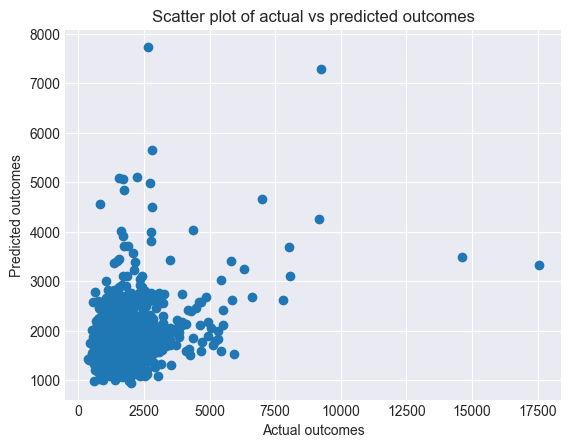

In [105]:
# plot the predicted outcomes against the actual outcomes in the testing set
plt.scatter(y_test, KNNy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.3 Decision Tree

In [106]:
# Dit algoritme heeft een score van 0.5646249872330892
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regressor object
dt_regressor = DecisionTreeRegressor(random_state=0)

# Fit the regressor with the training data
dt_regressor.fit(X_train, y_train)

# Predict the revenue on the testing data
y_pred_dt = dt_regressor.predict(X_test)

# Compute R^2 score on the testing data
r2_score_dt = dt_regressor.score(X_test, y_test)
print("R^2 Score (Decision Tree Regression): ", r2_score_dt)

# Predict the projected revenue for the 500 applicants

DTscore = scaler.transform(score)
DTpredictions = dt_regressor.predict(DTscore)

# Sort the predictions in descending order
DTsorted_index = np.argsort(DTpredictions)[::-1]
DTsorted_predictions = DTpredictions[DTsorted_index]

print(DTsorted_predictions)

R^2 Score (Decision Tree Regression):  0.5978208267386693
[5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45  5471.45
 5471.45  3150.23  3150.23  3150.23  3150.23  3150.23  3150.23  3150.23
 3150.

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Decision Tree

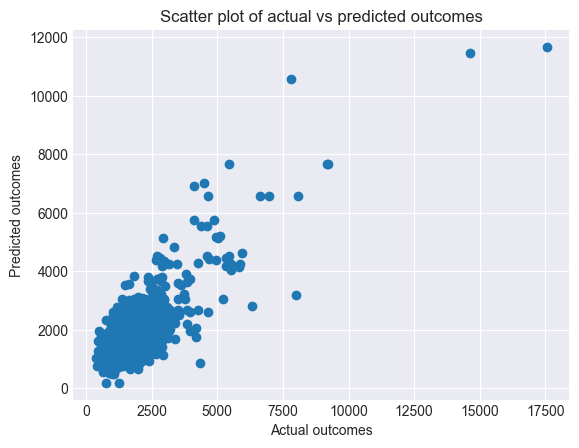

In [107]:
plt.scatter(y_test, y_pred_dt)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.4 Random Forest 

In [108]:
# Dit algoritme heeft een score van 0.7581997911409797
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test data
RFy_pred = rf.predict(X_test)

# Evaluate the model using r2 score
from sklearn.metrics import r2_score
RFr2 = r2_score(y_test, RFy_pred)
print("r2 score on test set:", RFr2)

# Predict the projected revenue for the 500 applicants

RFscore = scaler.transform(score)
RFpredictions = rf.predict(RFscore)

# Sort the predictions in descending order
RFsorted_index = np.argsort(RFpredictions)[::-1]
RFsorted_predictions = RFpredictions[RFsorted_index]

print(RFsorted_predictions)

r2 score on test set: 0.7605140674712514
[4496.24796667 4480.27706667 4469.45521667 4465.45846667 4461.06355
 4460.2218     4459.65452727 4458.773155   4458.47021667 4457.57428833
 4456.29036667 4456.01715    4455.551      4455.27621667 4454.70548833
 4453.0467     4452.64866667 4451.84983833 4451.7022     4451.14341667
 4449.76177727 4449.76177727 4448.712955   4448.2305     4448.14243833
 4447.860755   4447.370105   4446.99937727 4446.990955   4446.95846667
 4445.00308    4444.80773    4444.30586667 4441.091105   4439.68572727
 4439.062955   4438.95       4437.3999     4437.11546667 4437.00667727
 4435.056405   4433.59702727 4432.3991     4431.46278833 4429.8639
 4429.52958    4429.43389667 4428.2815     4427.38433    4426.66128833
 4426.14998833 4423.54398833 4422.00874667 4420.81623    4420.297755
 4420.297755   4417.90829667 4417.737505   4416.74549667 4416.54968833
 4416.30158    4413.71873    4412.06223833 4412.03715727 4410.70168833
 4410.296055   4409.52693833 4409.15128    44

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Random Forrest

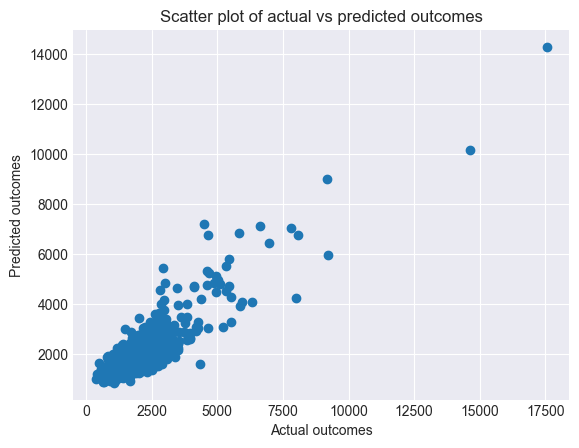

In [109]:
plt.scatter(y_test, RFy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.5 Gradient Boosting

In [110]:
# Dit algoritme heeft een score van 0.771681378659433
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Instantiate the model
GBmodel = GradientBoostingRegressor()

# Fit the model on the training data
GBmodel.fit(X_train, y_train)

# Make predictions on the testing data
GBy_pred = GBmodel.predict(X_test)

# Calculate the R-squared score on the testing data
GBr2 = r2_score(y_test, GBy_pred)
print("R-squared score on testing data:", GBr2)

# Predict the projected revenue for the 500 applicants

GBscore = scaler.transform(score)
GBpredictions = GBmodel.predict(GBscore)

# Sort the predictions in descending order
GBsorted_index = np.argsort(GBpredictions)[::-1]
GBsorted_predictions = GBpredictions[GBsorted_index]

print(GBsorted_predictions)

R-squared score on testing data: 0.770915175083682
[3207.6487253  3199.60973276 3190.54340927 3176.59849243 3169.76817696
 3149.76398786 3127.4689601  3120.78323269 3120.78323269 3116.33536576
 3112.74424015 3112.74424015 3110.87943176 3100.00800037 3098.14319198
 3098.14319198 3098.14319198 3098.14319198 3093.77411573 3090.76336746
 3090.76336746 3090.76336746 3078.02712768 3077.57164564 3077.57164564
 3077.36795967 3077.36795967 3077.36795967 3072.99888342 3064.83540586
 3064.83540586 3064.83540586 3064.83540586 3064.83540586 3064.83540586
 3064.83540586 3064.83540586 3050.46585102 3049.60686998 3047.73008984
 3047.73008984 3047.73008984 3045.47900153 3045.23334357 3044.06017355
 3044.06017355 3044.06017355 3044.06017355 3040.31798714 3031.9417183
 3028.83163767 3028.47687878 3018.99714714 3014.83640227 3012.07072272
 3000.56853656 2994.06116995 2987.83229678 2987.83229678 2970.72698075
 2967.05706447 2967.05706447 2967.05706447 2962.21131135 2962.21131135
 2962.21131135 2960.7486297

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Gradient Boosting

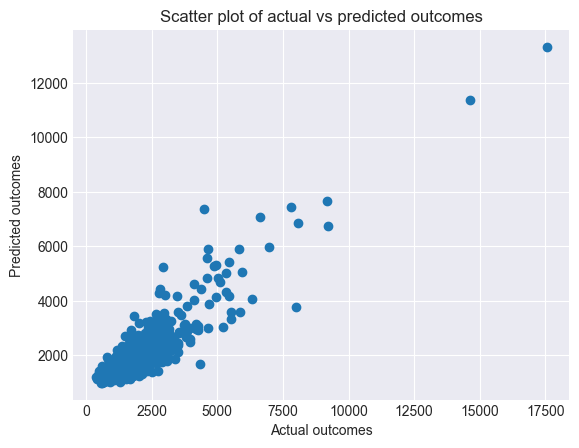

In [111]:
plt.scatter(y_test, GBy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.6.1 Polynomial

In [112]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)

# Split the dataset into training and testing sets
X = train
X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
y = train['outcome_profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [113]:
#check the number of features
X_train_poly.shape

(4000, 946)

In [114]:
#fit the linear regression
reg_quad = LinearRegression(fit_intercept=False)
reg_quad.fit(X_train_poly, y_train)


LinearRegression(fit_intercept=False)

In [115]:
print(reg_quad.score(X_train_poly, y_train))
print(reg_quad.score(X_test_poly, y_test))


0.7814238754096494
-3640.019254565362


The model is overfitted since it performs relatively well on the training set but not on the new data.

### Rate the models

In [116]:
from sklearn.model_selection import cross_val_score

# Define the evaluation metric (e.g., mean squared error)
metric = 'neg_mean_squared_error'

# Evaluate each algorithm using 10-fold cross-validation
scores = {}
for reg in [KNNmodel, reg_quad, GBmodel, rf, dt_regressor, LRmodel]:
    name = type(reg).__name__
    score = cross_val_score(reg, X, y, cv=10, scoring=metric)
    scores[name] = -score.mean()

# Print the mean squared error of each algorithm
for name, score in scores.items():
    print(f"{name}: {score:.4f}")

# 3. Conclusion Rating ML Algorithms

KNeighborsRegressor: 1543567.6565
LinearRegression: 1290593.4049
GradientBoostingRegressor: 423967.3419
RandomForestRegressor: 486162.5380
DecisionTreeRegressor: 904579.7700

We can see that gradientboosting has the lowest mean squared error so for this metric the gradientboosting scores the best.

# 2.1 Damages

Score the 500 applicants

### Split data in test/train and standardize

In [ ]:
print(type(num_feat))

In [ ]:
print(X_train.columns)

In [ ]:
print('damage_inc' in train.columns) # True

In [ ]:
# split into train and test sets
X = train
X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
y = train['damage_inc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# standardize numerical features
num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
scaler.fit(X_train[num_feat])
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

In [ ]:
# Voorgaande code dat niet werkte

# num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
# num_feat = [feat for feat in num_feat if feat in X_train.columns and feat in score.columns] # remove non-existent features
# scaler = StandardScaler()
# scaler.fit(X_train[num_feat])
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()
# X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
# X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

### 2.1.1 Decision Tree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# fit decision tree regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)
    scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit decision tree regressor to entire training set
dec_tree.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])


# Predict damages for new applicants using the trained decision tree regressor
damages_pred = dec_tree.predict(new_applicants_stand)

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage



### 2.1.3 Gradient Boosting

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# fit decision tree regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)
    scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit decision tree regressor to entire training set
dec_tree.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained decision tree regressor
damages_pred = dec_tree.predict(new_applicants_stand)
print(damages_pred)

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


### 2.1.4 KNN

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# fit KNN regressor with cross-validation
k_values = np.arange(1, 50)
cv_scores = []
sd_scores = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit KNN regressor to entire training set
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained KNN regressor
damages_pred = knn.predict(new_applicants_stand)
print(damages_pred)

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


## 2.1.5 Lineair Regression

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained linear regression model
damages_pred = lin_reg.predict(new_applicants_stand)
print(damages_pred)

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


### 2.1.6 Random Forest 

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# fit random forest regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    rnd_forest = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=d)
    scores = cross_val_score(rnd_forest, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit random forest regressor to entire training set
rnd_forest.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained random forest regressor
damages_pred = rnd_forest.predict(new_applicants_stand)
print(damages_pred) 

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


# 2.2 Predict damage amount

In [ ]:
 # TODO
 # Use all ML algorithms to predict damages:
    # - Linear Regression x
    # - Decision Tree x
    # - KNN x
    # - Random Forest x
    # - Gradient Boosting

### 2.2.1 Gradient Boosting

In [ ]:
# from random import Random
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import cross_val_score

# # split into train and test sets
# X = train
# X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
# y = train['damage_am']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # standardize numerical features
# num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
# num_feat = [feat for feat in num_feat if feat in X_train.columns and feat in score.columns] # remove non-existent features
# scaler = StandardScaler()
# scaler.fit(X_train[num_feat])
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()
# X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
# X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

# # fit Gradient Boosting regressor with cross-validation
# depth = np.arange(1, 10)
# cv_scores = []
# sd_scores = []
# for d in depth:
#     gb_regressor = GradientBoostingRegressor(random_state=0, n_estimators=100, max_depth=d)
#     scores = cross_val_score(gb_regressor, X_train_stand, y_train, cv=5)
#     cv_scores.append(scores.mean())
#     sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# # fit Gradient Boosting regressor to entire training set
# gb_regressor.fit(X_train_stand, y_train)

# # Predict damages for new applicants using the trained Gradient Boosting regressor
# damages_pred = gb_regressor.predict(applicants_who_will_cause_damage)
# damages_pred


### 2.2.2 Decision Tree Regressor

TODO Zorg ervoor dat de andere algoritmes ook de applicants_who_will_cause_damage gebruiken

In [ ]:
# # Decision Tree Regressor
# from random import Random
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import cross_val_score

# # split into train and test sets
# X = train
# X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
# y = train['damage_am']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # standardize numerical features
# num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
# num_feat = [feat for feat in num_feat if feat in X_train.columns and feat in score.columns] # remove non-existent features
# scaler = StandardScaler()
# scaler.fit(X_train[num_feat])
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()
# X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
# X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

# # fit decision tree regressor with cross-validation
# depth = np.arange(1, 50)
# cv_scores = []
# sd_scores = []
# for d in depth:
#     dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)
#     scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
#     cv_scores.append(scores.mean())
#     sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# # fit decision tree regressor to entire training set
# dec_tree.fit(X_train_stand, y_train)

# # Standardize numerical features for new applicants
# num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
# new_applicants_stand = score.copy()
# new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# # Predict damages for new applicants using the trained decision tree regressor
# damages_pred = dec_tree.predict(applicants_who_will_cause_damage)
# print(damages_pred)

### 2.2.3 KNN

In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import cross_val_score

# # split into train and test sets
# X = train
# X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
# y = train['damage_am']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # standardize numerical features
# num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
# num_feat = [feat for feat in num_feat if feat in X_train.columns and feat in score.columns] # remove non-existent features
# scaler = StandardScaler()
# scaler.fit(X_train[num_feat])
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()
# X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
# X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

# # fit KNN regressor with cross-validation
# k_values = np.arange(1, 50)
# cv_scores = []
# sd_scores = []
# for k in k_values:
#     knn = KNeighborsRegressor(n_neighbors=k)
#     scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
#     cv_scores.append(scores.mean())
#     sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# # fit KNN regressor to entire training set
# knn = KNeighborsRegressor(n_neighbors=5)
# knn.fit(X_train_stand, y_train)

# # Standardize numerical features for new applicants
# num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
# new_applicants_stand = score.copy()
# new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# # Predict damages for new applicants using the trained KNN regressor
# damages_pred = knn.predict(new_applicants_stand)
# print(damages_pred)


### 2.2.4 Random Forest

In [ ]:
# from random import Random
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score

# # split into train and test sets
# X = train
# X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
# y = train['damage_am']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # standardize numerical features
# num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
# num_feat = [feat for feat in num_feat if feat in X_train.columns and feat in score.columns] # remove non-existent features
# scaler = StandardScaler()
# scaler.fit(X_train[num_feat])
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()
# X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
# X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

# # fit random forest regressor with cross-validation
# depth = np.arange(1, 50)
# cv_scores = []
# sd_scores = []
# for d in depth:
#     rnd_forest = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=d)
#     scores = cross_val_score(rnd_forest, X_train_stand, y_train, cv=5)
#     cv_scores.append(scores.mean())
#     sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# # fit random forest regressor to entire training set
# rnd_forest.fit(X_train_stand, y_train)

# # Standardize numerical features for new applicants
# num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
# new_applicants_stand = score.copy()
# new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# # Predict damages for new applicants using the trained random forest regressor
# damages_pred = rnd_forest.predict(new_applicants_stand)
# print(damages_pred)


In [ ]:
# TODO
# To select the 200 applicants we will subtract the predicted damages from the predicted revenue
# Test the ML algortihms to determine which one is the best